# Developing the wideband sweep functionality:

Testing on the Cardiff KRM board connected to the Oxford RF breadboard with loopback cable in place of cryostat.

Create readout client and initialize the board:

In [1]:
%matplotlib inline

import sys
import os
import time 
import numpy as np
import matplotlib.pyplot as plt

#Move out of 'doc' and into the main directory above
os.chdir(os.path.dirname(os.path.abspath('')))

print("Importing readout_client")
import readout_client

print(os.getcwd())
config_file = 'config/breadboard_loopback.yaml'
client = readout_client.ReadoutClient(config_file)
client.set_config(config_file)

Importing readout_client
/home/sam/souk/souk_readout_tools


{'status': 'success'}

Set up some equally spaced tones to cover the full span of the readout band:

In [2]:
bandwidth = 2048e6 #TODO: add this to system_information

fmin = client.config['rf_frontend']['tx_mixer_lo_frequency_hz'] - bandwidth
fmax = client.config['rf_frontend']['tx_mixer_lo_frequency_hz']

num_tones = 1024 # somewhat arbitrary number of tones to use
lo_freq = 4e9 # get these from sysinfo or config file
if_bandwidth = 2048e6 # get these from sysinfo or config file
freqs,spacings = np.linspace(lo_freq-if_bandwidth,lo_freq,num_tones, endpoint=False, retstep=True)

sweep_points = 41 # not too many as its currently quite slow
sweep_spans = spacings * (sweep_points-1)/(sweep_points)
samples_per_point = 10 # dont need to integrate much

center_freqs = freqs + np.floor(sweep_points/2)*spacings/sweep_points
tone_amplitudes = np.ones(num_tones) # set_amplitudes to max
tone_phases = client.generate_newman_phases(center_freqs)

client.set_tone_frequencies(center_freqs)
client.set_tone_amplitudes(tone_amplitudes)
client.set_tone_phases(tone_phases)

print(client.check_output_saturation())
print(client.check_input_saturation())
print(client.check_dsp_overflow())



{'status': 'success', 'result': False, 'details': {'i0max_fs': 0.08245849609375, 'i0min_fs': -0.08245849609375, 'q0max_fs': 0.0823974609375, 'q0min_fs': -0.082427978515625, 'i1max_fs': 0.0, 'i1min_fs': 0.0, 'q1max_fs': 0.0, 'q1min_fs': 0.0, 'integration_time': 2e-05}}
{'status': 'success', 'result': False, 'details': {'imax_fs': 0.01422119140625, 'imin_fs': -0.014129638671875, 'qmax_fs': 0.014129638671875, 'qmin_fs': -0.013671875, 'integration_time': 2e-05}}
{'status': 'success', 'result': False, 'details': {'psbscale_ovf_count_start': 0, 'psbscale_ovf_count_end': 0, 'psbscale_ovf_delta': 0, 'psb_ovf_count_start': 331760, 'psb_ovf_count_end': 331760, 'psb_ovf_delta': 0, 'pfb_ovf_count_start': 0, 'pfb_ovf_count_end': 0, 'pfb_ovf_delta': 0}}


No overflow, indicated, so ready to perform the sweep:

In [3]:
import time 

#start the sweep
client.perform_sweep(center_freqs,
                     sweep_spans,
                     points = sweep_points,
                     samples_per_point = samples_per_point,
                     direction = 'up')

#wait for sweep to finish: 
#TODO make this an option in the perform_sweep function
while True:
     p=client.get_sweep_progress()
     print(f'sweep progress: {100*p:.3f}%',end='\r',flush=True)
     if p==1.0: break
     else: time.sleep(1)


Sweep is done, now check the results:

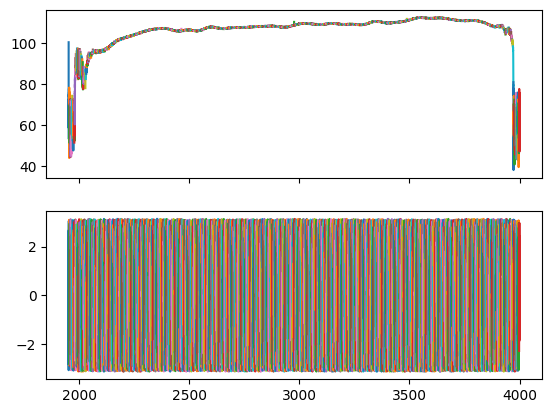

In [4]:
s = client.parse_sweep_data(client.get_sweep_data())
f = s['sweep_f'].T
z = s['sweep_i'].T+1j*s['sweep_q'].T

fig,(s1,s2) = plt.subplots(2,1,sharex=True)
s1.plot(f/1e6, 20*np.log10(abs(z)))
s2.plot(f/1e6, np.angle(z))
plt.show()

View a zoom in:

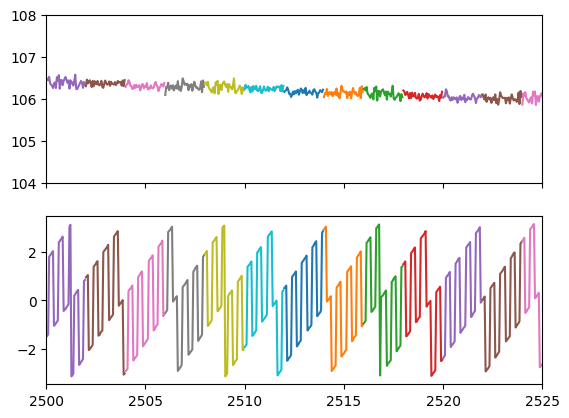

In [5]:
fig,(s1,s2) = plt.subplots(2,1,sharex=True)
s1.plot(f/1e6, 20*np.log10(abs(z)))
s2.plot(f/1e6, np.angle(z))
s1.set_xlim(2500,2525)
s1.set_ylim(104,108)
plt.show()

Note that the phase jumps by pi between filterbank channels, possibly due to the window function, which is simple to remove:

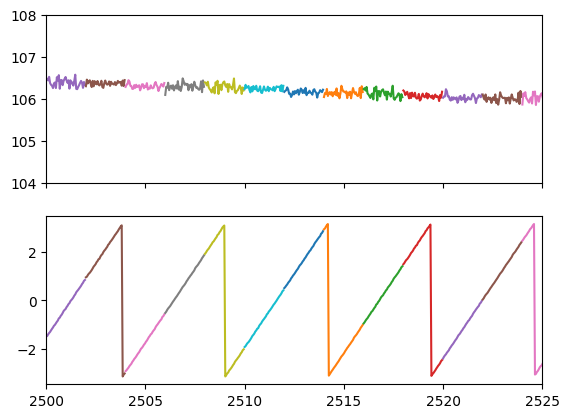

In [6]:
s = client.parse_sweep_data(client.get_sweep_data())
f = s['sweep_f'].T
z = s['sweep_i'].T+1j*s['sweep_q'].T

filterbank_bin_numbers = np.around(((4e9 - f)-1024e6)/1024e6*4096)
z[filterbank_bin_numbers%2==1]*=np.exp(1j*np.pi)

fig,(s1,s2) = plt.subplots(2,1,sharex=True)
s1.plot(f/1e6, 20*np.log10(abs(z)))
s2.plot(f/1e6, np.angle(z))
s1.set_xlim(2500,2525)
s1.set_ylim(104,108)
plt.show()


Next we can remove the phase slope, assuming its pretty constant across the whole band. 

First we flatten out and unwrap the phase. Then subtract off the average phase slope, then reshape back to the orginal shape.

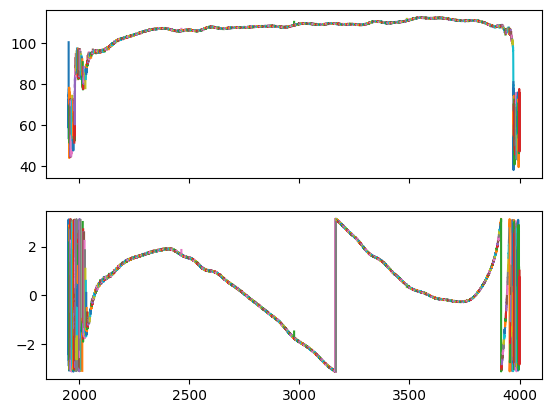

In [7]:
s = client.parse_sweep_data(client.get_sweep_data())
f = s['sweep_f'].T
z = s['sweep_i'].T+1j*s['sweep_q'].T

filterbank_bin_numbers = np.around(((4e9 - f)-1024e6)/1024e6*4096)
z[filterbank_bin_numbers%2==1]*=np.exp(1j*np.pi)

phi= np.unwrap(np.angle(np.ravel(z.T)))
slope = np.nanmedian(np.gradient(phi,np.ravel(f.T)))
z *= np.exp(-1j*slope*f)

fig,(s1,s2) = plt.subplots(2,1,sharex=True)
s1.plot(f/1e6, 20*np.log10(abs(z)))
s2.plot(f/1e6, np.angle(z))

plt.show()



And zooming in again:

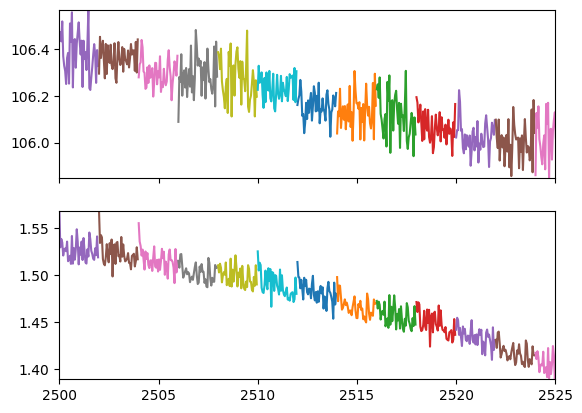

In [8]:
fig,(s1,s2) = plt.subplots(2,1,sharex=True)
s1.plot(f/1e6, 20*np.log10(abs(z)))
s2.plot(f/1e6, np.angle(z))

zmin=2500e6
zmax=2525e6
s1.set_xlim(zmin/1e6,zmax/1e6)
s1.set_ylim(np.min(20*np.log10(np.abs(z))[(f>zmin) & (f<zmax)]),
            np.max(20*np.log10(np.abs(z))[(f>zmin) & (f<zmax)]),
            )
s2.set_ylim(np.min(np.angle(z)[(f>zmin) & (f<zmax)]),
            np.max(np.angle(z)[(f>zmin) & (f<zmax)]),
            )
plt.show()


Which is looking much better, but there is still larger than expected variation in the magnitude and phases. 

This is possibly something to do with the fact the tones are exactly equally spaced and all the tones, harmonics and intermodulation products are landing on top of each other. 

If we add a amall, random frequency offset to the tones, we may see an improvement:


In [9]:
bandwidth = 2048e6 #TODO: add this to system_information

fmin = client.config['rf_frontend']['tx_mixer_lo_frequency_hz'] - bandwidth
fmax = client.config['rf_frontend']['tx_mixer_lo_frequency_hz']

num_tones = 1024 # somewhat arbitrary number of tones to use
lo_freq = 4e9
if_bandwidth = 2048e6
freqs,spacings = np.linspace(lo_freq-if_bandwidth,lo_freq,num_tones, endpoint=False, retstep=True)

sweep_points = 41 # not too many as its currently quite slow
sweep_spans = spacings * (sweep_points-1)/(sweep_points)
samples_per_point = 10 # dont need to integrate much

small_offsets = np.random.uniform(-sweep_spans/sweep_points/10,+sweep_spans/sweep_points/10,num_tones) # the offsets is less than 10% of the step size

small_offsets = np.around(small_offsets) # round to nearest integer

freqs += small_offsets

freqs = np.clip(freqs,fmin, fmax-sweep_spans) # make sure we dont exceeed the bandwidth during the sweep

center_freqs = freqs + np.floor(sweep_points/2)*sweep_spans/sweep_points

tone_amplitudes = np.ones(num_tones) # set_amplitudes to max
tone_phases = client.generate_newman_phases(center_freqs)

client.set_tone_frequencies(center_freqs)
client.set_tone_amplitudes(tone_amplitudes)
client.set_tone_phases(tone_phases)

print(client.check_output_saturation())
print(client.check_input_saturation())
print(client.check_dsp_overflow())


{'status': 'success', 'result': False, 'details': {'i0max_fs': 0.163482666015625, 'i0min_fs': -0.16497802734375, 'q0max_fs': 0.1640625, 'q0min_fs': -0.1708984375, 'i1max_fs': 0.0, 'i1min_fs': 0.0, 'q1max_fs': 0.0, 'q1min_fs': 0.0, 'integration_time': 2e-05}}
{'status': 'success', 'result': False, 'details': {'imax_fs': 0.024169921875, 'imin_fs': -0.02398681640625, 'qmax_fs': 0.0244140625, 'qmin_fs': -0.0245361328125, 'integration_time': 2e-05}}
{'status': 'success', 'result': False, 'details': {'psbscale_ovf_count_start': 0, 'psbscale_ovf_count_end': 0, 'psbscale_ovf_delta': 0, 'psb_ovf_count_start': 0, 'psb_ovf_count_end': 0, 'psb_ovf_delta': 0, 'pfb_ovf_count_start': 0, 'pfb_ovf_count_end': 0, 'pfb_ovf_delta': 0}}


In [10]:
#start the sweep
client.perform_sweep(center_freqs,
                     sweep_spans,
                     points = sweep_points,
                     samples_per_point = samples_per_point,
                     direction = 'up')

#wait for sweep to finish: 
#TODO make this an option in the perform_sweep function
while True:
     p=client.get_sweep_progress()
     print(f'sweep progress: {100*p:.3f}%',end='\r',flush=True)
     if p==1.0: break
     else: time.sleep(1)

s = client.parse_sweep_data(client.get_sweep_data())
f = s['sweep_f'].T
z = s['sweep_i'].T+1j*s['sweep_q'].T

filterbank_bin_numbers = np.around(((4e9 - f)-1024e6)/1024e6*4096)
z[filterbank_bin_numbers%2==1]*=np.exp(1j*np.pi)


phi= np.unwrap(np.angle(np.ravel(z.T)))
slope = np.nanmedian(np.gradient(phi,np.ravel(f.T)))
z *= np.exp(-1j*slope*f)


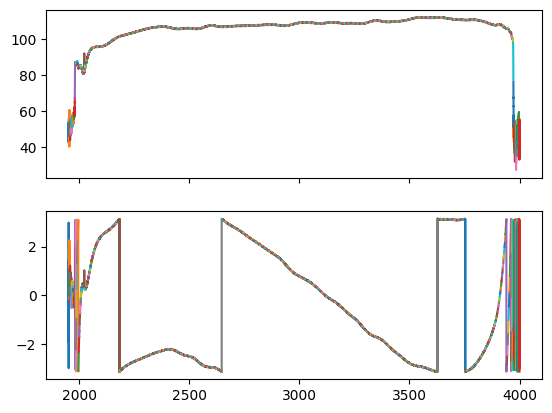

In [11]:
fig,(s1,s2) = plt.subplots(2,1,sharex=True)
s1.plot(f/1e6, 20*np.log10(abs(z)))
s2.plot(f/1e6, np.angle(z))
plt.show()

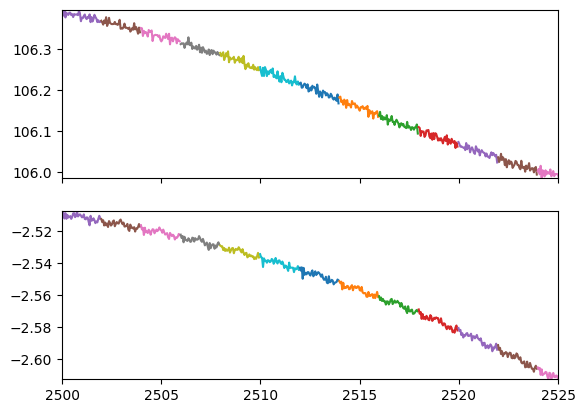

In [12]:

fig,(s1,s2) = plt.subplots(2,1,sharex=True)
s1.plot(f/1e6, 20*np.log10(abs(z)))
s2.plot(f/1e6, np.angle(z))
zmin=2500e6
zmax=2525e6
s1.set_xlim(zmin/1e6,zmax/1e6)
s1.set_ylim(np.min(20*np.log10(np.abs(z))[(f>zmin) & (f<zmax)]),
            np.max(20*np.log10(np.abs(z))[(f>zmin) & (f<zmax)]),
            )
s2.set_ylim(np.min(np.angle(z)[(f>zmin) & (f<zmax)]),
            np.max(np.angle(z)[(f>zmin) & (f<zmax)]),
            )

plt.show()


Note that the noise has dropped right down now.

Its also worth noting that the crest factor of the waveform is minimised when the tones are exactly equally spaced:


No random frequency offset, exactly equal spacing, Newman phases
2000000.0 2000000.0000002384
True
CF =  1.8979537453286457 1.8979448928100098
CF dB =  5.565712482233152 5.565671969033396

Small random frequency offsets, Newman phases
2000000.0 2189295.0
False
CF =  4.4358964388370445 4.173528209271661
CF dB =  12.939627969710997 12.410067065692713

Large random frequency offsets, Newman phases
2000000.0 5832764.0
False
CF =  4.751711830539849 4.937968056550788
CF dB =  13.537001896191622 13.87096552354809

Large random frequency offsets, completely random phases
2000000.0 5832764.0
False
CF =  5.334086442001086 5.14018915348893
CF dB =  14.541200988156582 14.219582017278945


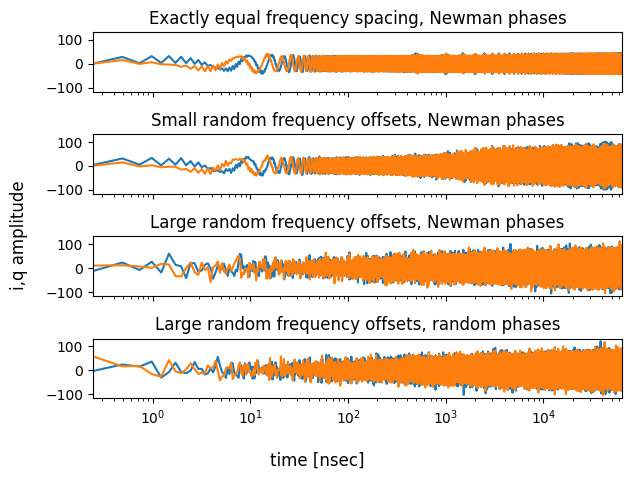

In [30]:
freqs,spacings = np.linspace(4e9-2048e6,4e9,num_tones, endpoint=False, retstep=True)

sweep_points = 41 # not too many as its currently quite slow
sweep_spans = spacings * (sweep_points-1)/(sweep_points)
samples_per_point = 10 # dont need to integrate much

nsamples = 4096*64
sample_rate = 4096e6

fig,(s1,s2,s3,s4) = plt.subplots(4,1,sharex=True,sharey=True)


print('\nNo random frequency offset, exactly equal spacing, Newman phases')

center_freqs = freqs + np.floor(sweep_points/2)*spacings/sweep_points
tone_amplitudes = np.ones(num_tones) # set_amplitudes to max
tone_phases = client.generate_newman_phases(center_freqs)

print(spacings,max(np.diff(center_freqs)))
print(np.all(np.isclose(np.diff(center_freqs),spacings)))

zz = np.zeros(nsamples,dtype=complex)
for k in range(len(center_freqs)):
    zz += tone_amplitudes[k]*np.exp(1j*(2*np.pi*center_freqs[k]*np.arange(nsamples)/sample_rate + tone_phases[k]))

cfi = max(abs(zz.real))/(np.sqrt(np.mean(zz.real**2))) 
cfq = max(abs(zz.imag))/(np.sqrt(np.mean(zz.imag**2)))
print('CF = ',cfi, cfq)
print('CF dB = ', 20*np.log10(abs(cfi)), 20*np.log10(abs(cfq)))
s1.plot(np.arange(nsamples)/sample_rate*1e9,zz.real)
s1.plot(np.arange(nsamples)/sample_rate*1e9,zz.imag)
s1.title.set_text(f'Exactly equal frequency spacing, Newman phases, CF={20*np.log10(max(cfi,cfq)):.2f}dB}')



print('\nSmall random frequency offsets, Newman phases')

center_freqs += np.random.uniform(-spacings/20,+spacings/20,num_tones) # the offsets is less than 10% of the spacing
center_freqs = np.around(center_freqs) # round to nearest integer
tone_amplitudes = np.ones(num_tones) # set_amplitudes to max
tone_phases = client.generate_newman_phases(center_freqs)

print(spacings,max(np.diff(center_freqs)))
print(np.all(np.isclose(np.diff(center_freqs),spacings)))

zz = np.zeros(nsamples,dtype=complex)
for k in range(len(center_freqs)):
    zz += tone_amplitudes[k]*np.exp(1j*(2*np.pi*center_freqs[k]*np.arange(nsamples)/sample_rate + tone_phases[k]))

cfi = max(abs(zz.real))/(np.sqrt(np.mean(zz.real**2))) 
cfq = max(abs(zz.imag))/(np.sqrt(np.mean(zz.imag**2)))
print('CF = ',cfi, cfq)
print('CF dB = ', 20*np.log10(abs(cfi)), 20*np.log10(abs(cfq)))
s2.plot(np.arange(nsamples)/sample_rate*1e9,zz.real)
s2.plot(np.arange(nsamples)/sample_rate*1e9,zz.imag)
s2.title.set_text('Small random frequency offsets, Newman phases, CF={20*np.log10(max(cfi,cfq)):.2f}dB}')



print('\nLarge random frequency offsets, Newman phases')

center_freqs += np.random.uniform(-spacings,+spacings,num_tones) # the offsets are about the same as the spacing
center_freqs = np.around(center_freqs) # round to nearest integer
tone_amplitudes = np.ones(num_tones) # set_amplitudes to max
tone_phases = client.generate_newman_phases(center_freqs)

print(spacings,max(np.diff(center_freqs)))
print(np.all(np.isclose(np.diff(center_freqs),spacings)))

zz = np.zeros(nsamples,dtype=complex)
for k in range(len(center_freqs)):
    zz += tone_amplitudes[k]*np.exp(1j*(2*np.pi*center_freqs[k]*np.arange(nsamples)/sample_rate + tone_phases[k]))

cfi = max(abs(zz.real))/(np.sqrt(np.mean(zz.real**2))) 
cfq = max(abs(zz.imag))/(np.sqrt(np.mean(zz.imag**2)))
print('CF = ',cfi, cfq)
print('CF dB = ', 20*np.log10(abs(cfi)), 20*np.log10(abs(cfq)))
s3.plot(np.arange(nsamples)/sample_rate*1e9,zz.real)
s3.plot(np.arange(nsamples)/sample_rate*1e9,zz.imag)
s3.title.set_text('Large random frequency offsets, Newman phases, CF={20*np.log10(max(cfi,cfq)):.2f}dB}')



print('\nLarge random frequency offsets, completely random phases')

tone_phases = client.generate_random_phases(center_freqs)

print(spacings,max(np.diff(center_freqs)))
print(np.all(np.isclose(np.diff(center_freqs),spacings)))

zz = np.zeros(nsamples,dtype=complex)
for k in range(len(center_freqs)):
    zz += tone_amplitudes[k]*np.exp(1j*(2*np.pi*center_freqs[k]*np.arange(nsamples)/sample_rate + tone_phases[k]))

cfi = max(abs(zz.real))/(np.sqrt(np.mean(zz.real**2))) 
cfq = max(abs(zz.imag))/(np.sqrt(np.mean(zz.imag**2)))
print('CF = ',cfi, cfq)
print('CF dB = ', 20*np.log10(abs(cfi)), 20*np.log10(abs(cfq)))
s4.plot(np.arange(nsamples)/sample_rate*1e9,zz.real)
s4.plot(np.arange(nsamples)/sample_rate*1e9,zz.imag)
s4.title.set_text('Large random frequency offsets, random phases, CF={20*np.log10(max(cfi,cfq)):.2f}dB}')


plt.semilogx()
plt.xlim((np.arange(nsamples)/sample_rate*1e9)[1],
         (np.arange(nsamples)/sample_rate*1e9)[-1])
fig.supxlabel('time [nsec]')
fig.supylabel('i,q amplitude')
fig.tight_layout()

